In [1]:
import message_ix
from message_ix import log
import ixmp as ix
import numpy as np
from scripts_for_diagnostics import *
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

fs = 18
plt.style.use('seaborn-ticks')
plt.rcParams['axes.labelsize'] = fs
plt.rcParams['xtick.labelsize'] = fs
plt.rcParams['ytick.labelsize'] = fs
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['axes.axisbelow'] = True

<IPython.core.display.Javascript object>

In [21]:
mp = ix.Platform('local',jvmargs=["-Xmx8G"])

In [22]:
sc_ref = message_ix.Scenario(mp, model="MESSAGEix-GLOBIOM", scenario="ENGAGE_SSP2_EN_NPi2020_500",version=1)
# scen_pypsa = message_ix.Scenario(mp, model="MESSAGEix-GLOBIOM", scenario="ENGAGE_SSP2_EN_NPi2020_500_PyPSA_Eur")
scen_ref_only_curt = message_ix.Scenario(mp, model="MESSAGEix-GLOBIOM", scenario="ENGAGE_SSP2_EN_NPi2020_500_remove_all_but_curtailment")
scen_pypsa_only_curt = message_ix.Scenario(mp, model="MESSAGEix-GLOBIOM", scenario="ENGAGE_SSP2_EN_NPi2020_500_PyPSA_Eur_remove_all_but_curtailment")

In [24]:
###############################################
case = "new" # in this notebook, we evaluate the new formulation obtained from the softlinkage with PyPSA-Eur
###############################################
scenarios = {"old":scen_ref_only_curt,
             "new":scen_pypsa_only_curt}
regions = ["R11_WEU","R11_EEU"]
scen = scenarios[case]
model_years = [x for x in scen.set("year") if x >= scen.firstmodelyear and x <= 2110]
curt_list = [x for x in scen.set("relation") if "curtailment" in x]
technologies = {
    "solar": [x for x in set(scen.set("technology")) if any([y in x for y in ["solar_res"]])], 
    "wind": [x for x in set(scen.set("technology")) if any([y in x for y in ["wind_res", "wind_ref"]])], 
    "wind curtailed": [x for x in set(scen.set("technology")) if "wind_curt" in x],
    "solar curtailed": [x for x in set(scen.set("technology")) if "solar_curt" in x],
    "storage": ["stor_ppl"],
    "export": [x for x in set(scen.set("technology")) if "elec_exp" in x],
    "import": [x for x in set(scen.set("technology")) if "elec_imp" in x],
    "e-mobility": ["elec_trp"],
    "electrolysis": ["h2_elec"],
    "fuel cell": ["h2_fc_I", "h2_fc_RC"],
    "load": ["elec_t_d"],
    }

bins_old = [1,2,3]

In [25]:
vre_list = ["vre_curtailment_w" + str(i) + "s" + str(j) for i in range(1,8) for j in range(1,8)]

# vre relations 
vre_curt_rel = scen.par("relation_activity",
                        {"node_loc": regions,
                        "year_rel":2050,
                        "relation":vre_list,}).relation.unique().tolist()

bins = list(pd.Index(vre_curt_rel).str.split("_",expand=True).get_level_values(2))

In [38]:
scen.par("relation_activity",
         {"node_loc": regions,
          "year_rel":2050,
          "relation":"vre_curtailment_w6s1",})

,relation,node_rel,year_rel,node_loc,technology,year_act,mode,value,unit
0,vre_curtailment_w6s1,R11_WEU,2050,R11_WEU,elec_trp,2050,M1,-0.083333,???
1,vre_curtailment_w6s1,R11_WEU,2050,R11_WEU,h2_elec,2050,M1,-0.105263,???
2,vre_curtailment_w6s1,R11_WEU,2050,R11_WEU,elec_exp_eurasia,2050,M1,-0.450000,???
3,vre_curtailment_w6s1,R11_WEU,2050,R11_WEU,elec_imp_eurasia,2050,M1,0.450000,???
4,vre_curtailment_w6s1,R11_WEU,2050,R11_WEU,elec_exp_eur_afr,2050,M1,-0.450000,???
5,vre_curtailment_w6s1,R11_WEU,2050,R11_WEU,elec_imp_eur_afr,2050,M1,0.450000,???
6,vre_curtailment_w6s1,R11_WEU,2050,R11_WEU,solar_curtailment1,2050,M1,0.000000,GWa
7,vre_curtailment_w6s1,R11_WEU,2050,R11_WEU,wind_curtailment6,2050,M1,0.350000,GWa
8,vre_curtailment_w6s1,R11_WEU,2050,R11_WEU,vre_curtailmentw6s1,2050,M1,-1.000000,GWa
9,vre_curtailment_w6s1,R11_EEU,2050,R11_EEU,solar_curtailment1,2050,M1,0.000000,GWa


# Energy and capacity mix 

First, we show the results obtained with the reference scenario with the original VRE representation:

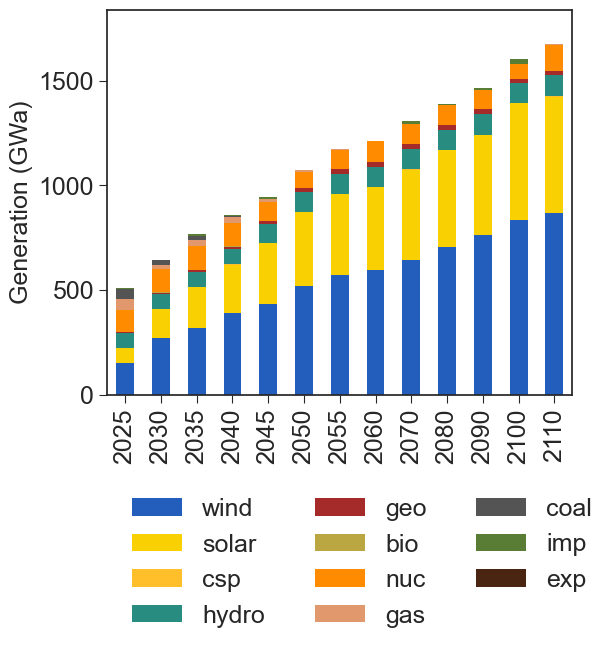

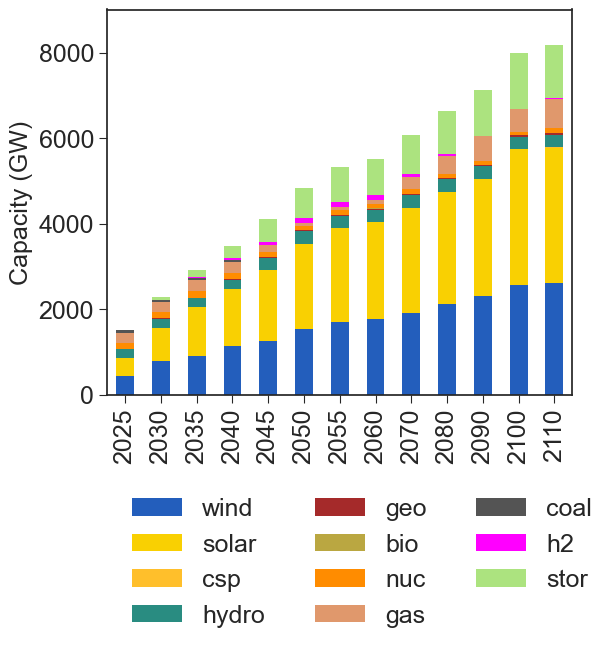

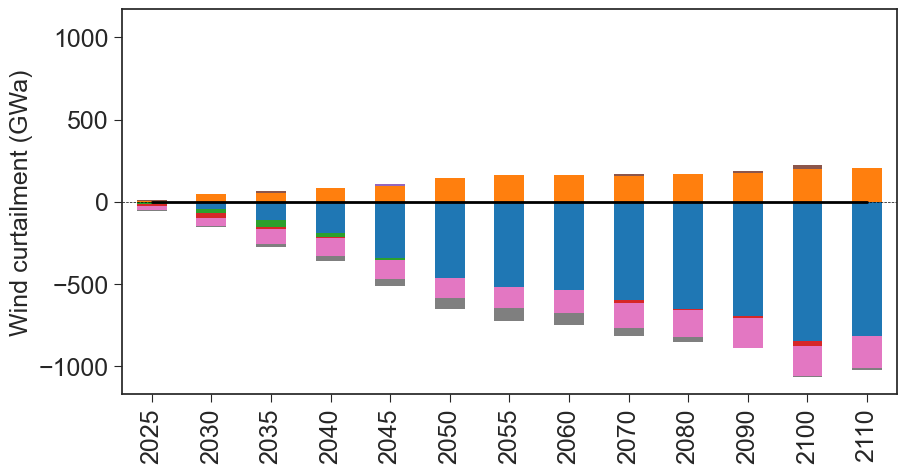

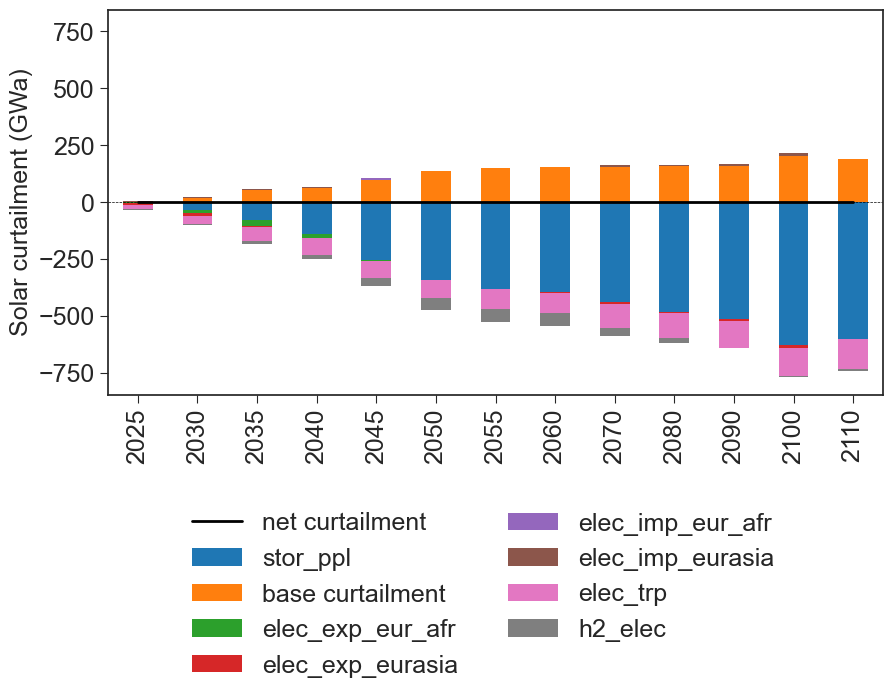

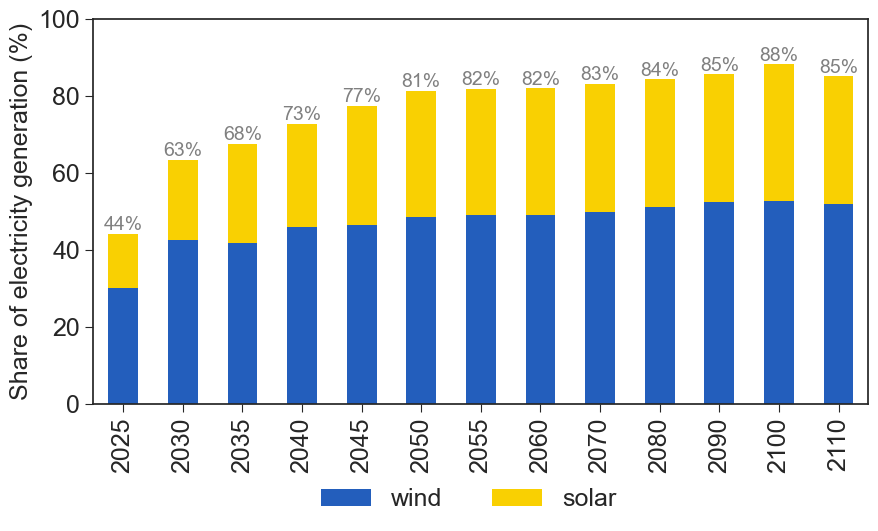

In [8]:
fig1, fig2, fig3, fig4, fig5, df_generation_ref, df_capacity_ref, tech_cap_ref, tech_act_ref, VRE_share_ref = plot_generation_and_capacity(scen_ref_only_curt, regions, technologies, model_years, bins_old, formulation="old")

In [10]:
# df_generation_ref.loc[2050].to_csv("../PyPSA-Eur/generation_MESSAGE.csv")
# df_capacity_ref.loc[2050].to_csv("../PyPSA-Eur/capacity_MESSAGE.csv")

df_generation_ref.loc[2050].to_csv("../PyPSA-Eur/generation_MESSAGE_only_curt.csv")
df_capacity_ref.loc[2050].to_csv("../PyPSA-Eur/capacity_MESSAGE_only_curt.csv")

In [62]:
# fig3.savefig("figures/wind_curtailment_current_formulation.png", 
#              bbox_inches='tight',
#              dpi=300)

# fig4.savefig("figures/solar_curtailment_current_formulation.png",
#                 bbox_inches='tight',
#                 dpi=300)

Then, we show the results obtained with the PyPSA-Eur softlink:

In [39]:
scen.var("CAP",
         {"node_loc": regions,
          "technology":  technologies["wind"] ,
          "year_act": 2050}).groupby("technology").sum()

,year_vtg,year_act,lvl,mrg
technology,,,,
wind_ref1,16340,16400,0.000000,1.602813e+01
wind_ref2,16340,16400,0.000000,1.676555e+01
wind_ref3,16340,16400,0.000000,4.922704e+00
wind_ref4,16340,16400,0.000000,1.456307e+01
wind_ref5,16340,16400,0.000000,1.036646e+01
wind_res1,24450,24600,48.137500,1.318194e+01
wind_res2,24450,24600,0.000000,3.575271e+01
wind_res3,24450,24600,2.293548,2.918893e+01
wind_res4,24450,24600,2.655556,9.618014e+00


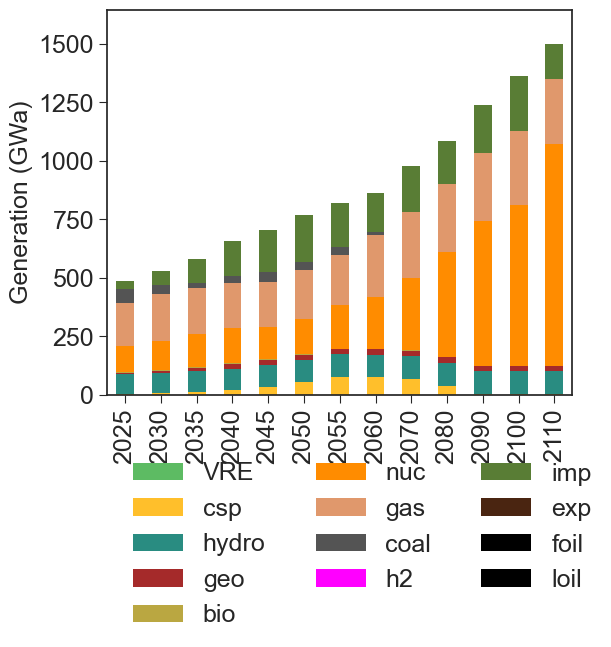

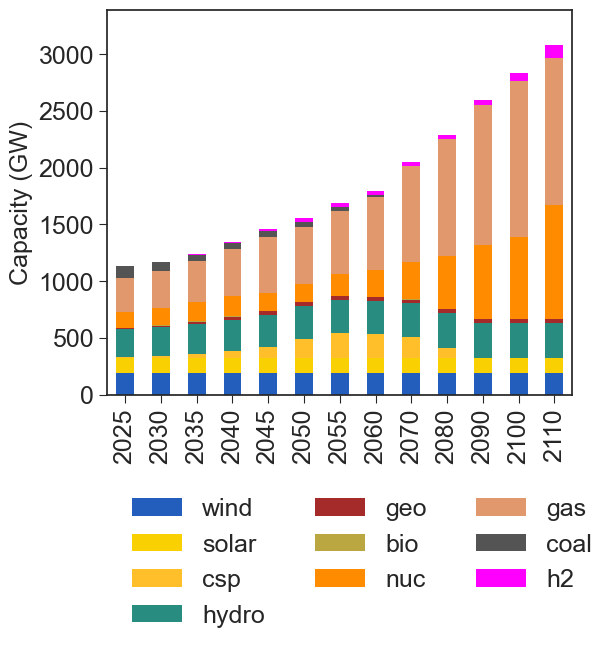

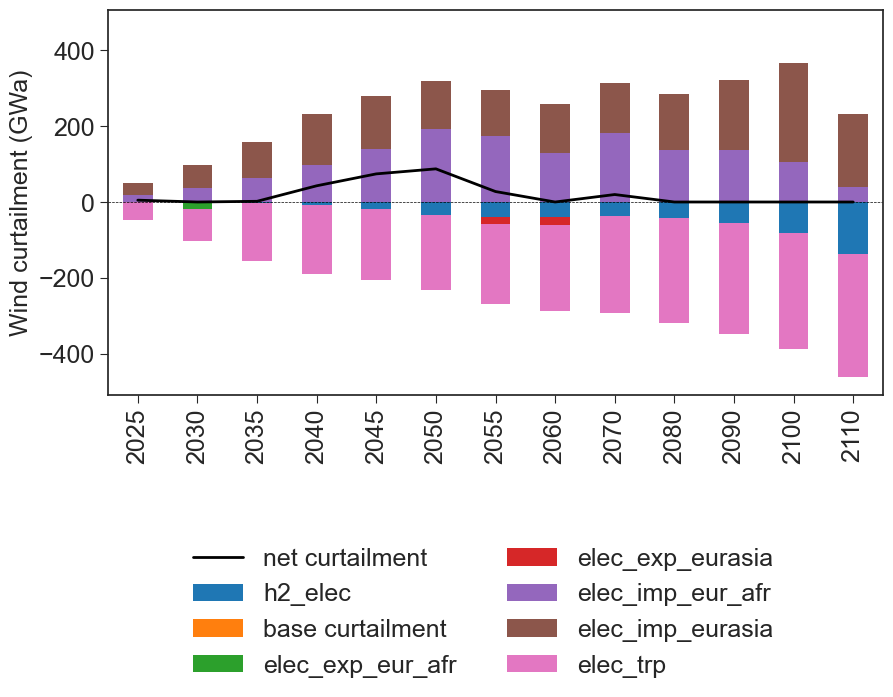

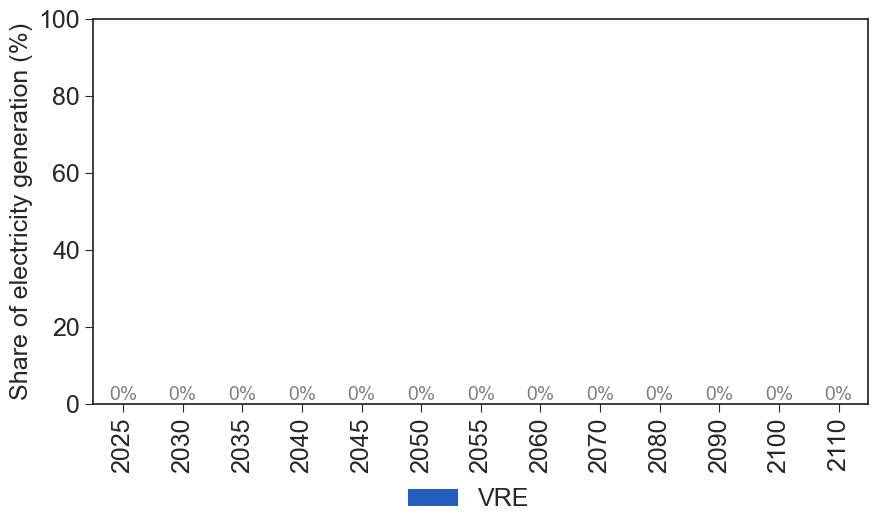

In [40]:
fig1, fig2, fig3, fig4, fig5, df_generation, df_capacity, tech_cap, tech_act, VRE_share = plot_generation_and_capacity(scen, regions, technologies, model_years, bins, formulation="new")

In [ ]:
df_generation.loc[2050].to_csv("../PyPSA-Eur/generation_MESSAGE_w_PyPSA.csv")
df_capacity.loc[2050].to_csv("../PyPSA-Eur/capacity_MESSAGE_w_PyPSA.csv")

Difference:

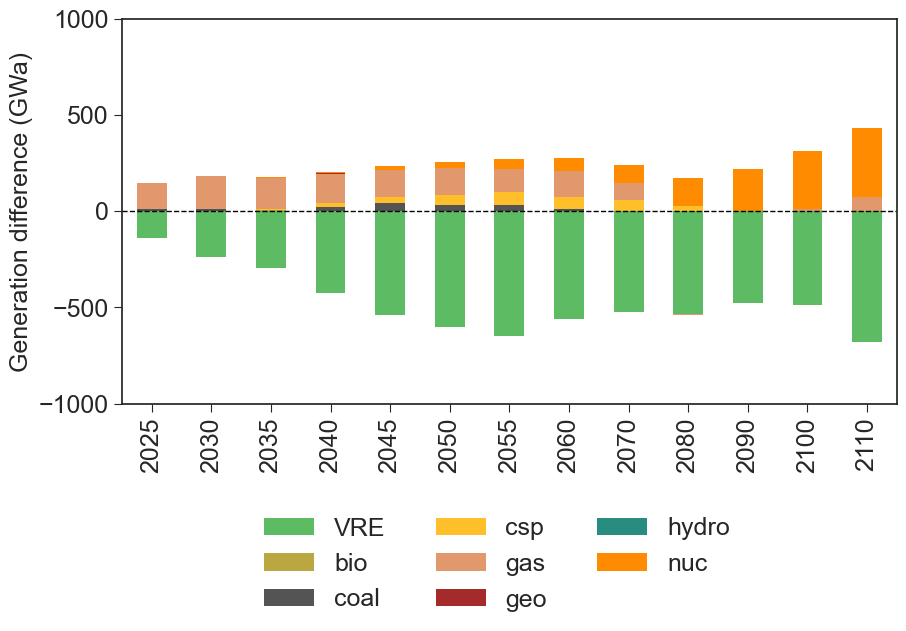

In [ ]:
# in df_generation_ref rename wind and solar to VRE
df_generation_ref = df_generation_ref.rename(columns={"wind":"VRE","solar":"VRE"})
# then group by column names
df_generation_ref = df_generation_ref.groupby(df_generation_ref.columns, axis=1).sum()

df_diff = df_generation - df_generation_ref
fig, ax = plt.subplots(figsize=(10,5))
df_diff.plot.bar(stacked=True, ax = ax,
                 color=[colors_dict[i] for i in df_diff.columns])

ax.set_ylabel("")
ax.axhline(0,color="k",ls="--",lw=1)
ax.set_ylim(-1000,1000)
ax.legend().remove()
ax.set_xlabel("")
ax.set_ylabel("Generation difference (GWa)")
fig.legend(loc="lower center", bbox_to_anchor=(0.5, -0.35), ncol=3, fontsize=fs)

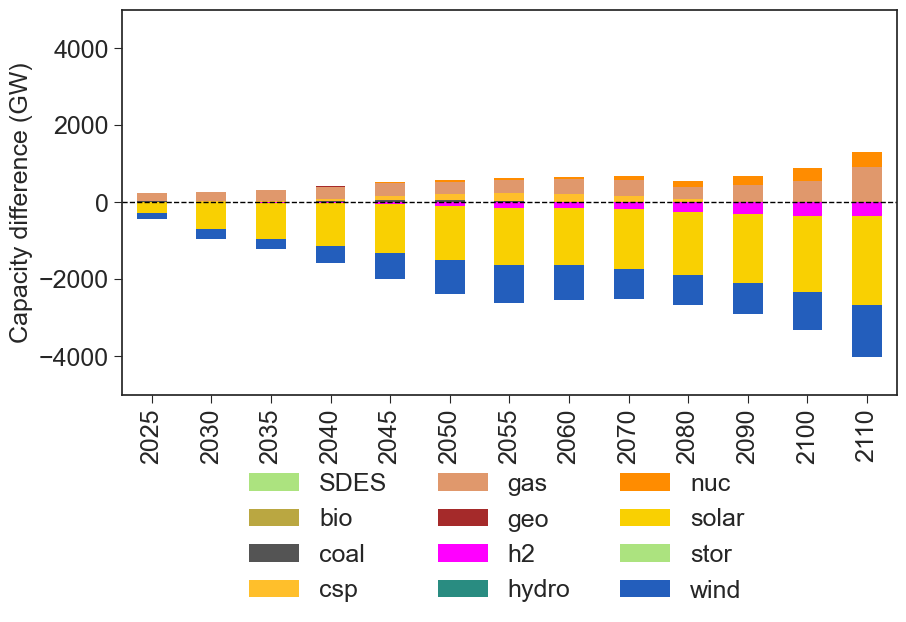

In [ ]:
df_diff = (df_capacity - df_capacity_ref)
fig, ax = plt.subplots(figsize=(10,5))
df_diff.plot.bar(stacked=True, ax = ax,
                 color=[colors_dict[i] for i in df_diff.columns])

ax.set_ylabel("")
ax.axhline(0,color="k",ls="--",lw=1)
ax.set_ylim(-5000,5000)
ax.legend().remove()
ax.set_xlabel("")
ax.set_ylabel("Capacity difference (GW)")
fig.legend(loc="lower center", bbox_to_anchor=(0.5, -0.35), ncol=3, fontsize=fs)

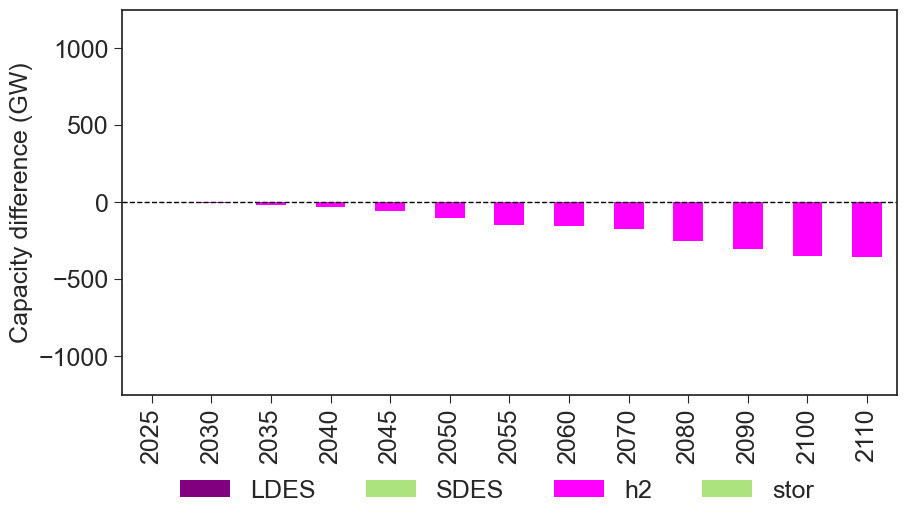

In [ ]:
df_diff = (tech_cap - tech_cap_ref)
df_diff = df_diff.unstack().T
df_diff.rename(columns={"h2_elec":"h2","stor_ppl":"stor"},inplace=True)
fig, ax = plt.subplots(figsize=(10,5))
df_diff.plot.bar(stacked=True, ax = ax,
                 color=[colors_dict[i] for i in df_diff.columns])

ax.set_ylabel("")
ax.axhline(0,color="k",ls="--",lw=1)
ax.set_ylim(-1250,1250)
ax.legend().remove()
ax.set_xlabel("")
ax.set_ylabel("Capacity difference (GW)")
fig.legend(loc="lower center", bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=fs)

In [20]:
mp.close_db()